# **PV Fault Detection**

Projemizin amacı güneş panellerindeki arızaları tespit eden bir derin öğrenme modeli oluşturmaktır. Bunu güneş panellerininin resimlerinin bulunduğu bir dataset yardımıyla gerçekleştireceğiz.

Kullandığımız dataset`in linki : https://github.com/zae-bayern/elpv-dataset

Derin öğrenme modelimize geçmeden önce bizim için önemli olmayan uyarıların gösterilmemesi için aşağıdaki kodu uygularız :

In [1]:
import warnings

warnings.filterwarnings('ignore')

## **1. Projeye Dataseti Yükleme**

Projemizde güneş paneli resimlerini içeren bir klasör ve bu resimlere ait arıza yüzdelerini içeren bir CSV dosyası bulunmaktadır. Bu iki kaynağı birleştirerek, resimlerle ilişkilendirilmiş arıza yüzdelerini içeren bir DataFrame oluşturmak istiyoruz.

Bu amaçla; dosya işlemleri, görüntü işleme, veri analizi ve manipülasyonu için gerekli kütüphaneleri uygularız :   

In [2]:
import os       # Dosya işlemleri.
import cv2      # Görüntü işleme.
import pandas as pd     # Veri analizi ve manipülasyonu.

### **1.1 Resimlerin Olduğu Kaynağı Yükleme**

İlk olarak, güneş paneli resimlerinin bulunduğu veri setini projemize yüklüyoruz. Modeli eğitmek için kullanmadan önce, her bir resmi matrix formuna dönüştürmeli ardından bu matrixleri bir dataframe`e eklemeliyiz. Bunu aşağıdaki kod bloğu ile yaparız.

In [3]:
# Resimlerin bulunduğu dizin :
image_directory = "./elpv-dataset-master/images"

# Tüm resim dosyalarını bir listeye atadık :
image_files = [f for f in os.listdir(image_directory) if f.endswith('.png')]

# Resimleri listeye karışık eklediğinden dolayı isimlerine göre sıraladık :
image_files.sort()

# Boş bir DataFrame oluşturduk :
df = pd.DataFrame()

# Listeki tüm resimleri dolaştık :
for image_file in image_files:

    image_path = os.path.join(image_directory, image_file)      # Resmin url`sini okuduk.
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı olarak okuduk.

    # Resmi düzleştirip ve DataFrame'e ekledik :
    img_vector = img.flatten()
    df = df._append(pd.Series(img_vector), ignore_index=True)

Güneş paneli resimlerinin bulunduğu dataseti df adında bir dataframe`e aktardıktan sonra satır ve sütun sayıları ile ilk 5 satırını aşağıdaki kod bloğu ile gösteriyoruz.

In [4]:
print(f'Row - Column : {df.shape}')
df.head()    # dataframe`mizn ilk 5 satırını gösterdik.

Row - Column : (2624, 90000)


,0,1,2,3,4,5,6,7,8,9,...,89990,89991,89992,89993,89994,89995,89996,89997,89998,89999
0,14,14,14,15,16,17,17,17,17,17,...,22,22,22,21,21,20,18,18,18,4
1,29,29,29,28,28,29,29,29,28,29,...,14,15,14,14,12,12,11,12,12,10
2,29,29,30,30,30,30,30,30,30,30,...,27,26,24,23,23,22,21,21,12,0
3,35,35,35,36,36,36,36,36,37,38,...,31,30,29,29,28,26,25,24,3,0
4,39,39,40,40,40,40,41,41,41,41,...,35,34,33,30,29,29,28,23,0,0


### **1.2 Arıza Yüzdelerini İçeren Kaynağı Yükleme**

Arıza yüzdelerini içeren dataseti yüklemek için aşağıdaki kod bloğunu uygularız : 

In [5]:
label = pd.read_csv("./elpv-dataset-master/labels.csv", sep="\s+", header=None)
columnHeads = ["Image Name", "Fault", "Mono"]
label.columns = columnHeads
print(f'Row - Column {label.shape}')
label.head()

Row - Column (2624, 3)


,Image Name,Fault,Mono
0,images/cell0001.png,1.0,mono
1,images/cell0002.png,1.0,mono
2,images/cell0003.png,1.0,mono
3,images/cell0004.png,0.0,mono
4,images/cell0005.png,1.0,mono


Arıza yüzdelerini içeren veri seti, başlangıçta tek bir sütundan oluşuyordu. İlk incelemede, bu veri setinin daha fazla sütuna ayrılması gerektiğini fark ettik. **sep="\s+"** ifadesi, bir veya daha fazla boşluk karakteri ile ayrılmış sütunları belirleyerek, sonunda 3 sütundan oluşan bir DataFrame elde etmemize yardımcı oldu. Başlangıçta başlıklar olmadığı için **header=None** parametresini kullandık ve daha sonra başlıkları kendimiz belirledik.

### **1.3 İki Kaynağı Birleştirme**

Resimleri temsil eden cvs dosyası ile (df) arıza yüzdelerini içeren csv dosyasının Fault sütununu (label[Fault]) birleştireceğiz. Aşağıda, bu birleştirme işlemini gerçekleştirmek için kullanılabilecek kod bloğunu bulabilirsiniz : 

In [6]:
merged_df = pd.concat([label["Fault"], df], axis=1)
print(f'Row - Column : {merged_df.shape}')
merged_df.head()

Row - Column : (2624, 90001)


,Fault,0,1,2,3,4,5,6,7,8,...,89990,89991,89992,89993,89994,89995,89996,89997,89998,89999
0,1.0,14,14,14,15,16,17,17,17,17,...,22,22,22,21,21,20,18,18,18,4
1,1.0,29,29,29,28,28,29,29,29,28,...,14,15,14,14,12,12,11,12,12,10
2,1.0,29,29,30,30,30,30,30,30,30,...,27,26,24,23,23,22,21,21,12,0
3,0.0,35,35,35,36,36,36,36,36,37,...,31,30,29,29,28,26,25,24,3,0
4,1.0,39,39,40,40,40,40,41,41,41,...,35,34,33,30,29,29,28,23,0,0


**Not :** axis=1 parametresi, sütunlarda işlem yapılacağını belirtir. Eğer satırlarda işlem yapmak isteseydik, axis=0 olarak belirtmemiz gerekecekti.

## **2. Data Visualization (Veri Görselleştirme)**

Veri Görselliştirmek için gerekli olan kütüphaneyi uygularız : 

In [7]:
import matplotlib.pyplot as plt     # Veri görselleştirme.

### **2.1 Arıza Dağılım Grafiği**

Arıza yüzdelerini pasta grafiği şeklinde göstermek için aşağıdaki kod bloğunu uyguladık : 

In [8]:
def pieplot(df, column_name):
  distribution = df[column_name].value_counts()
  plt.figure(figsize = (7, 8))
  plt.pie(distribution, labels = distribution.index, autopct = "%1.1f%%")
  plt.title(column_name)
  plt.legend(loc = "best")
  plt.show()

Yukarıdaki pieplot fonksiyonu, bir dataframe (df) ve bir sütun ismi (column_name) alarak, bu sütunun benzersiz değerlerini bulur ve bu değerlerin veri setindeki oranlarını gösteren bir pasta grafiği çizer. Yani, fonksiyon, belirtilen sütunun içindeki farklı kategorilerin dağılımını görsel olarak temsil eder.

Aşağıda bu fonksiyonu uyguladık : 

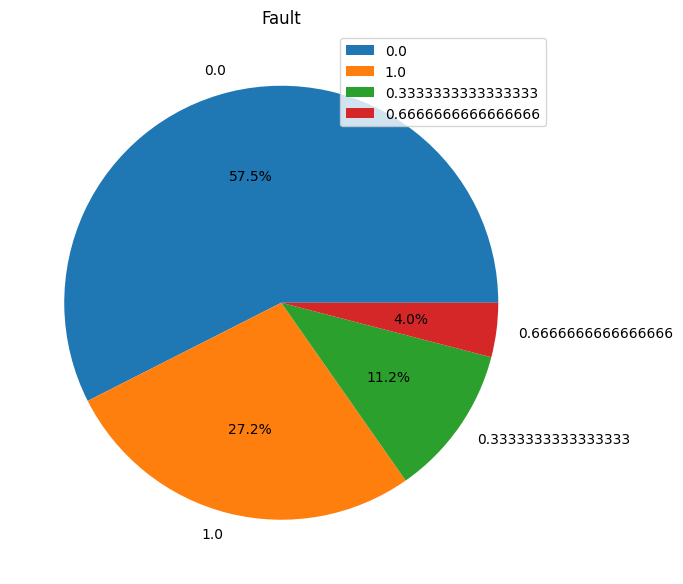

In [9]:
pieplot(merged_df, "Fault")

### **2.2 Veri Setindeki Bazı Resimlerin Gösterimi**

Resimleri gösterebilmek için aşağıdaki fonksiyonu uygularız : 

In [10]:
def showImage(df, imageId):
  # DataFrame'den ilk satırı alır ve tekrar boyutlandırırz :
  image_matrix = df.iloc[imageId - 1].to_numpy().reshape(300, 300)

  # Matrisi bir resme dönüştürürüz : 
  plt.imshow(image_matrix, cmap='gray')
  plt.axis('off') 
  plt.show()

Aşağıda datasetimizdeki ilk resmi gösterdik. Bu panel %100 hasarlıdır.

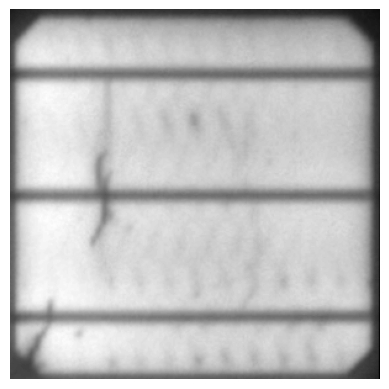

In [11]:
showImage(df, 1)

Aşağıda datasetimizdeki 4. resmi gösterdik. Bu panel hiç hasarlı değildir.

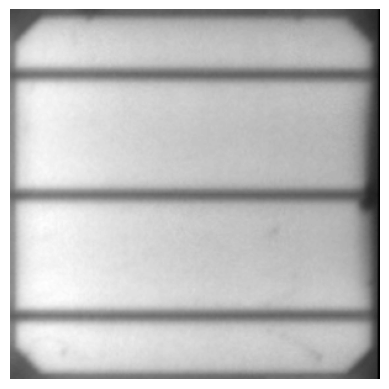

In [12]:
showImage(df, 4)

Aşağıda datasetimizdeki 58. resmi gösterdik. Bu panel %33 hasarlıdır.

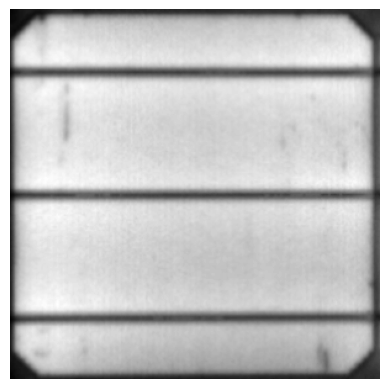

In [13]:
showImage(df, 58)

## **3. Normalizasyon**

Derin öğrenme modelimizin daha etkili ve performanslı olabilmesi için, büyük boyuttaki veri kümesini daha küçük boyutlara dönüştürmemiz gerekiyor. Bu amaçla, normalizasyon işlemi uygulamamız gerekmektedir. Normalizasyon, verileri 0 ve 1 arasında yeniden ölçekler. 

In [14]:
from sklearn.preprocessing import MinMaxScaler

def normalize(df):
    label = df["Fault"]
    normalized_df = df.drop("Fault", axis=1)

    min_max_scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(min_max_scaler.fit_transform(normalized_df), columns=normalized_df.columns)

    normalized_df = pd.concat([label, normalized_df], axis=1)
    return normalized_df

In [15]:
normalized_df = normalize(merged_df)

print(f'Row - Column : {normalized_df.shape}')
normalized_df.head()

Row - Column : (2624, 90001)


,Fault,0,1,2,3,4,5,6,7,8,...,89990,89991,89992,89993,89994,89995,89996,89997,89998,89999
0,1.0,0.105263,0.105263,0.106061,0.113636,0.123077,0.130769,0.130769,0.130769,0.128788,...,0.162963,0.165414,0.165414,0.159091,0.159091,0.151515,0.137405,0.137405,0.136364,0.030303
1,1.0,0.218045,0.218045,0.219697,0.212121,0.215385,0.223077,0.223077,0.223077,0.212121,...,0.103704,0.112782,0.105263,0.106061,0.090909,0.090909,0.083969,0.091603,0.090909,0.075758
2,1.0,0.218045,0.218045,0.227273,0.227273,0.230769,0.230769,0.230769,0.230769,0.227273,...,0.200000,0.195489,0.180451,0.174242,0.174242,0.166667,0.160305,0.160305,0.090909,0.000000
3,0.0,0.263158,0.263158,0.265152,0.272727,0.276923,0.276923,0.276923,0.276923,0.280303,...,0.229630,0.225564,0.218045,0.219697,0.212121,0.196970,0.190840,0.183206,0.022727,0.000000
4,1.0,0.293233,0.293233,0.303030,0.303030,0.307692,0.307692,0.315385,0.315385,0.310606,...,0.259259,0.255639,0.248120,0.227273,0.219697,0.219697,0.213740,0.175573,0.000000,0.000000


## **4. Derin Öğrenmeye Giriş**

Derin öğrenme modelimizi oluşturmak için CNN (Convolutional Neural Network) kullanacağız. Bu amacı gerçekleştirmek için öncelikle gerekli kütüphaneleri uyguluyoruz :

In [47]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

### **4.1 Train Test Dosyalarını Oluşturmak**

In [57]:
x = normalized_df.drop(["Fault"], axis = 1)
y = normalized_df.Fault

clf_x = x.copy();   # RandomForestClassifier için.

x = x.values.reshape(-1, 300, 300, 1)       # reshape. Burada CNN modeli için resimlerimizi 4 boyutlu hale çeviriyoruz.

# label encoding. Burada veri setimizin Fault sütununun 4 tane değer alabildiğini belirtiyoruz.
label_encoder = LabelEncoder()
integer_faults = label_encoder.fit_transform(y)
y = to_categorical(integer_faults, num_classes=4)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 42)

In [58]:
print(f'x_train shape : {x_train.shape}')
print(f'x_test shape : {x_test.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'y_test shape : {y_test.shape}')

x_train shape : (1574, 300, 300, 1)
x_test shape : (1050, 300, 300, 1)
y_train shape : (1574, 4)
y_test shape : (1050, 4)


### **4.2 CNN Modelinin Oluşturulması**

In [59]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

epochs = 20
batch_size = 128

### **4.3 Modelin Derlenmesi ve Eğitilmesi**

In [60]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))



Epoch 1/20
13/13 [==============================] - 56s 3s/step - loss: 6.4783 - accuracy: 0.4511 - val_loss: 1.2035 - val_accuracy: 0.6581
Epoch 2/20
13/13 [==============================] - 28s 2s/step - loss: 1.2323 - accuracy: 0.3996 - val_loss: 1.0121 - val_accuracy: 0.6048
Epoch 3/20
13/13 [==============================] - 29s 2s/step - loss: 1.0211 - accuracy: 0.6093 - val_loss: 0.9830 - val_accuracy: 0.6229
Epoch 4/20
13/13 [==============================] - 28s 2s/step - loss: 0.9823 - accuracy: 0.6213 - val_loss: 0.9654 - val_accuracy: 0.6238
Epoch 5/20
13/13 [==============================] - 28s 2s/step - loss: 0.9481 - accuracy: 0.6487 - val_loss: 0.9068 - val_accuracy: 0.6686
Epoch 6/20
13/13 [==============================] - 28s 2s/step - loss: 0.9182 - accuracy: 0.6728 - val_loss: 0.9031 - val_accuracy: 0.6676
Epoch 7/20
13/13 [==============================] - 29s 2s/step - loss: 0.8945 - accuracy: 0.6804 - val_loss: 0.8691 - val_accuracy: 0.6686
Epoch 8/20
13/13 [==

In [71]:
# Modeli test seti üzerinde değerlendirme
accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy[1]:.4}%')

33/33 [==============================] - 5s 151ms/step - loss: 0.8527 - accuracy: 0.7029
Test Accuracy: 0.7029%


### **4.4 Confusion Matrix**

33/33 [==============================] - 5s 157ms/step


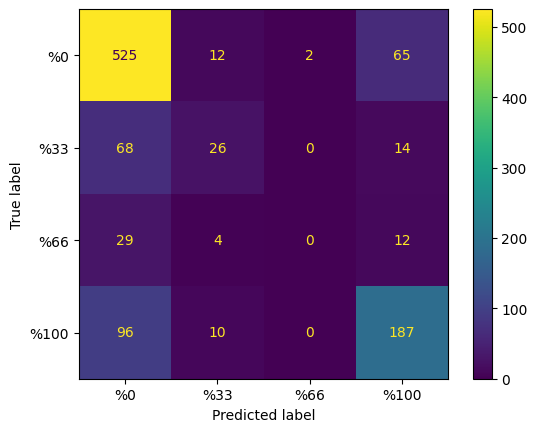

In [72]:
from sklearn import metrics
import numpy as np

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 

y_true = np.argmax(y_test, axis = 1) 

confusion_matrix = metrics.confusion_matrix(y_true, y_pred_classes) 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["%0", "%33", "%66", "%100"])
cm_display.plot()
plt.show()

### **4.5 Random Forest Classifier**

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train-test ayırma işlemi
x_train, x_test, y_train, y_test = train_test_split(clf_x, y, test_size=0.3, random_state=42)

# RandomForestClassifier'ı başlatma ve eğitme
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(x_train, y_train)

# Eğitim seti üzerinde tahmin yapma
train_predictions = clf.predict(x_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Doğrulama seti üzerinde tahmin yapma
val_predictions = clf.predict(x_test)
val_accuracy = accuracy_score(y_test, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.4f}')


Training Accuracy: 0.9995
Validation Accuracy: 0.6053


**NOT :** EfficientNet modeli ölçeklendirme yöntemi kullanarak, CNN modellerinin doğruluğunu ve verimliliğini artırmayı amaçlar. Bu yöntem, modeli küçültmeye çalışırken derinlik, genişlik ve çözünürlükten yalnızca birinde değil her üçünde de ölçekleme yapmak çok daha efektif sonuçlar üretmeyi sağlar. EfficientNet grubu B0-B7 arasında 8 tane modelden oluşur ve sayı büyüdükçe hesaplanan parametre sayısı ve doğruluk artar.
